In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#df = pd.read_csv('../occupancy_data/time_series/original/training_ts.csv', parse_dates = True, index_col=['date']).drop('Unnamed: 0', 1)

In [ ]:
#df.head()

Per farlo funzionare in colab

In [7]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=False)

dir_progetto = '/content/drive/My Drive/Project DM2'
os.chdir(dir_progetto)

#aggiunta della directory drive alla directory di sistema per caricare gli script python
sys.path.append(dir_progetto)
sys.path.append(os.path.join(dir_progetto,'dataset/Time series'))
df = pd.read_csv('dataset/Time series/training_ts.csv', parse_dates = True, index_col=['date']).drop('Unnamed: 0', 1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

## Univariate time series

### With hour as time window

In [ ]:
ts1 =  df[['Temperature']].resample('H').median()

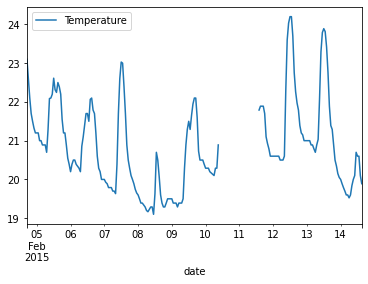

In [ ]:
ts1.plot()

(Mancano i dati per parte del 10/02 e parte dell'11/02)

In [ ]:
ts2 = df[['Light']].resample('H').median()

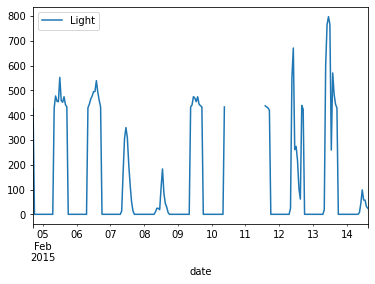

In [ ]:
ts2.plot()

## Motif discovery

In [ ]:
!pip install stumpy
import stumpy as sp

### Temperature

In [ ]:
ts1=  df[['Temperature']].resample('H').median()

I missing value della serie non sembrano essere un problema per il matrix profile, quindi non li ho trattati in nessun modo

In [ ]:
# questo passaggio è necessario perché altrimenti il comando sp.stump interpreta l'indice come una colonna. Così
# facendo, invece, teniamo solo i valori di Temperature in una lista che non ha indice particolari e quindi usa un banale 
# indice sequenziale
temp = []
for index in ts1.index:
    temp.append(ts1.at[index,'Temperature'])

In [ ]:
ts1 = temp

In [ ]:
mp1 = sp.stump(ts1, m=8)

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


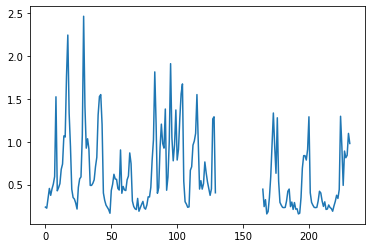

In [ ]:
plt.plot(mp1[:, 0])

In [ ]:
ts1 =  df[['Temperature']].resample('H').median()

In [ ]:
# trova ed enumera nel dataframe della time series i motif o le anomalie e visualizza maschera
# che mostra le modifiche significative effettuate al dataframe
def mark_ts(threshold, motifs = True, radius = 1.5, ts = ts1, mp = mp1):
    
    # preparo la ts
    ts['Index'] = 0
    j= 0
    for index in ts.index:
        ts.at[index,'Index'] = j
        j += 1

    #preparo il matrix profile
    mp = pd.DataFrame(mp)
    
    used_indices = []
    counter = 0
    if motifs == True:
        # ordiniamo il dataframe del matrix profile in ordine di distanza 
        #(dalla distanza più piccola a quella più grande):
        mp.sort_values(by=0, inplace=True)
        ts['Motif'] = 'no'
        for index in mp.index:
            if(counter < threshold):
                if index not in used_indices:
                    counter +=1
                    used_indices.append(index)
                    used_indices.append(mp.at[index,1])
                    distance = mp.at[index,0]
                    indices = [index, mp.at[index,1]]
                    for index2 in ts.index:
                        if (ts.at[index2, 'Index'] == index) or (ts.at[index2, 'Index'] == mp.at[index,1]):
                            ts.at[index2, 'Motif'] = str(counter)
                    for index2 in mp.index:
                        if (index2 not in used_indices) and (mp.at[index2,1] in indices) and (mp.at[index2, 0] <= distance*radius):
                            used_indices.append(index2)
                            for index3 in ts.index:
                                if ts.at[index3, 'Index'] == index2:
                                    if ts.at[index3,'Motif'] == 'no':
                                        ts.at[index3,'Motif'] = str(counter)
                                    elif ts.at[index3, 'Motif'] != str(counter):
                                        ts.at[index3, 'Motif'] += ", " + str(counter)
        return ts[ts['Motif']!='no'].sort_values('Motif')
    elif motifs == False:
        mp.sort_values(by=0, ascending = False, inplace = True)
        ts['Anomaly'] = 'no'
        for index in mp.index:
            if(counter < threshold):
                if index not in used_indices:
                    counter +=1
                    used_indices.append(index)
                    used_indices.append(mp.at[index,1])
                    distance = mp.at[index,0]
                    indices = [index, mp.at[index,1]]
                    for index2 in ts.index:
                        if (ts.at[index2, 'Index'] == index) or (ts.at[index2, 'Index'] == mp.at[index,1]):
                            ts.at[index2, 'Anomaly'] = str(counter)
                    for index2 in mp.index:
                        if (index2 not in used_indices) and (mp.at[index2,1] in indices) and (mp.at[index2, 0] <= distance*radius):
                            used_indices.append(index2)
                            for index3 in ts.index:
                                if ts.at[index3, 'Index'] == index2:
                                    if ts.at[index3,'Anomaly'] == 'no':
                                        ts.at[index3,'Anomaly'] = str(counter)
                                    elif ts.at[index3, 'Anomaly'] != str(counter):
                                        ts.at[index3, 'Anomaly'] += ", " + str(counter)
        return ts[ts['Anomaly']!='no'].sort_values('Anomaly')

In [ ]:
mark_ts(6, motifs=True)

,Temperature,Index,Motif
date,,,
2015-02-11 17:00:00,21.8900,168,1
2015-02-12 17:00:00,21.9725,192,1
2015-02-06 18:00:00,21.2000,49,2
2015-02-11 18:00:00,21.7000,169,2
2015-02-12 18:00:00,21.7900,193,2
2015-02-07 16:00:00,20.8900,71,3
2015-02-13 19:00:00,20.8900,218,3
2015-02-04 18:00:00,22.6000,1,4
2015-02-06 17:00:00,21.7000,48,4


In [ ]:
motif_len = 6
motif_index = {}
for i in range(1, motif_len+1):
    idx = ts1.loc[ts1['Motif'] == str(i)].iloc[0].Index
    motif_index[i] = idx
motif_index

{1: 168, 2: 49, 3: 71, 4: 1, 5: 188, 6: 73}

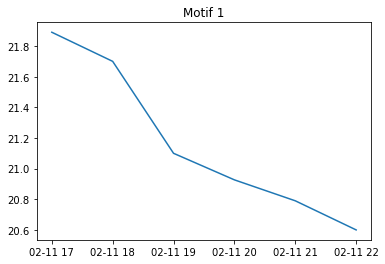

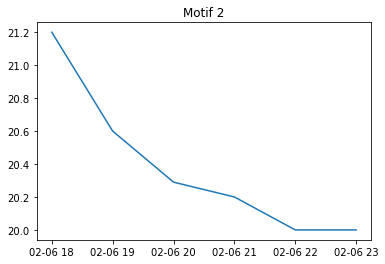

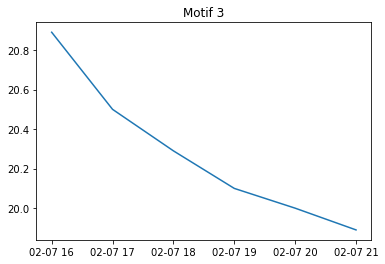

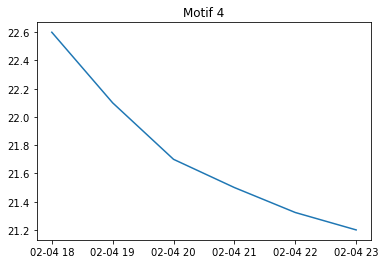

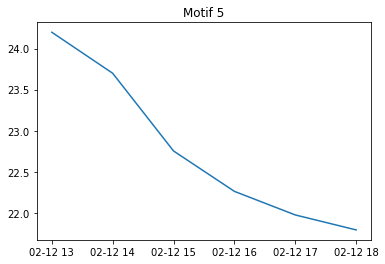

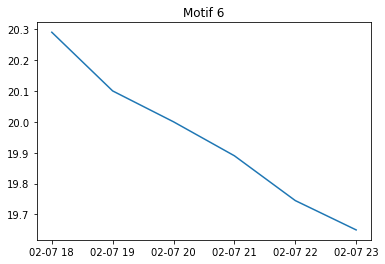

In [ ]:
motif_len = 6
motif_index = {}
for i in range(1, motif_len+1):
    idx = ts1.loc[ts1['Motif'] == str(i)].iloc[0].Index
    motif_index[i] = idx
motif_index
# per ogni motif possibile
for key, value in motif_index.items():
    # seleziona i 6 punti del motig
    ts_mot = ts1.iloc[value : value + motif_len]
    plt.plot(ts_mot['Temperature'])
    plt.title('Motif '+ str(key))
    plt.show()


In [ ]:
# mark_ts(6, motifs=False)
mark_ts(7, motifs=False)

,Temperature,Index,Motif,Anomaly
date,,,,
2015-02-10 13:00:00,NaN,140,no,1
2015-02-10 10:00:00,NaN,137,no,1
2015-02-10 11:00:00,NaN,138,no,1
2015-02-10 12:00:00,NaN,139,no,1
2015-02-10 14:00:00,NaN,141,no,1
2015-02-10 15:00:00,NaN,142,no,1
2015-02-10 16:00:00,NaN,143,no,1
2015-02-10 17:00:00,NaN,144,no,1
2015-02-10 09:00:00,20.890000,136,no,1


In [ ]:
ts1.loc[ts1['Anomaly'] == '2'].iloc[0].Index

29

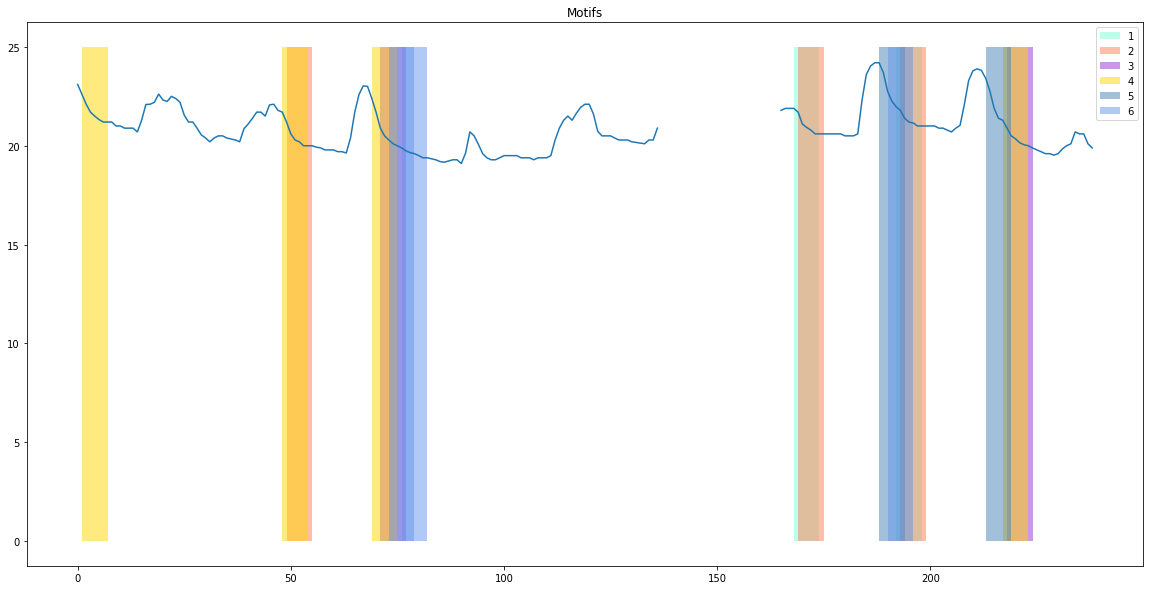

In [ ]:
from matplotlib.patches import Rectangle as Rect
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(20, 10))

n_rows = 239
min_height = 0
max_height = 25
# l'insieme dei motif da plottare
motif_list = ts1[ts1['Motif']!='no']
# questo serve perché erano stringhe
motif_list = motif_list.astype({'Motif': 'int32'})

#Plotta la ts
axs.plot(ts1['Temperature'].values)

# divido i motif per categoria
ids = list(motif_list['Motif'].unique())
# assegno a ogni motif un colore diverso (ne vanno aggiunti, se ne servono di più)
label_cols = {1 : '#7FFFD4', 2 : '#FF7F50', 3 : '#9932CC', 4 : '#FFD700', 5 : '#4682B4', 6: '#6495ED'}

# splitto il motif_list in df contenenti un unico tipo di motif
for motif_id in np.sort(ids):
    data = motif_list[motif_list['Motif'] == motif_id]
    # mi interessano solo le posizioni
    data = data['Index'].values
    for datum in data:
        # stampo i rect di quel motif dandogli il colore giusto rect((x, y), width, height)
        rect = Rect((datum, min_height), 6, max_height, facecolor=label_cols[motif_id], alpha=.5, label=motif_id)
        axs.add_patch(rect)

plt.title('Motifs')
# questa parte serve per plottare la legenda senza duplicare le label di ogni rettangolo
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

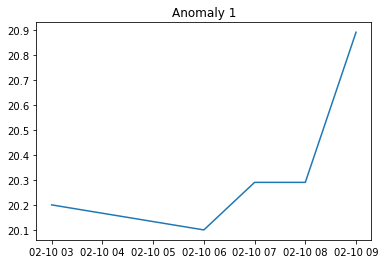

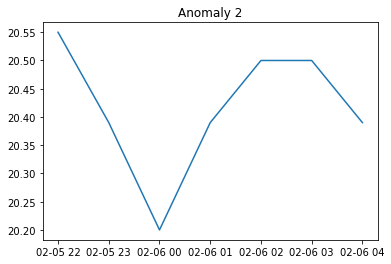

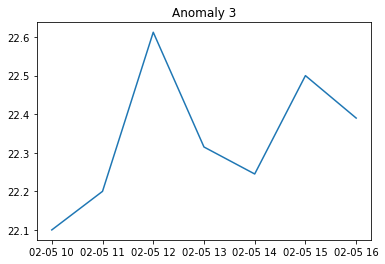

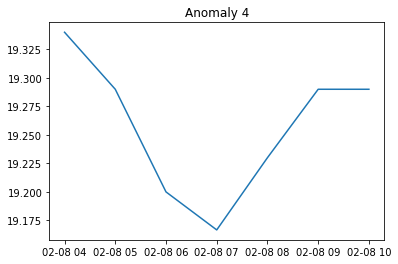

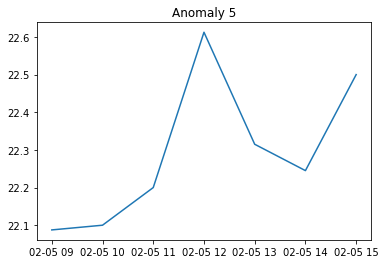

In [ ]:
anomalies_len = 7
anomalies_index = {}
for i in range(2, motif_len+1):
    idx = ts1.loc[ts1['Anomaly'] == str(i-1)].iloc[0].Index
    anomalies_index[i-1] = idx


# per ogni motif possibile
for key, value in anomalies_index.items():
    # seleziona i 6 punti del motig
    ts_mot = ts1.iloc[value : value + anomalies_len]
    plt.plot(ts_mot['Temperature'])
    plt.title('Anomaly '+ str(key))
    plt.show()


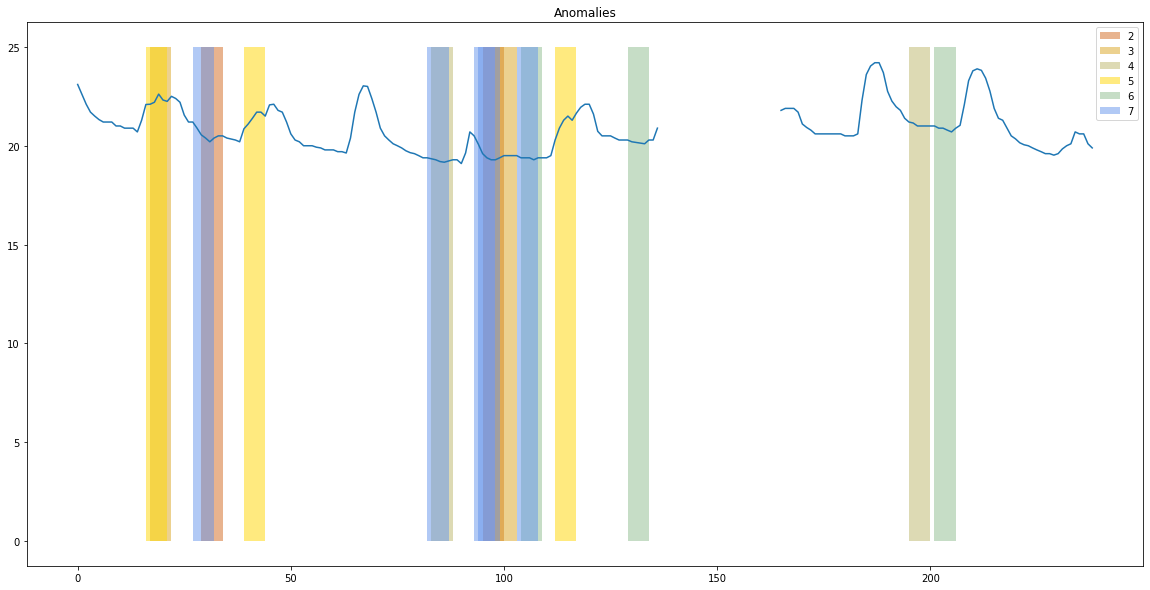

In [ ]:
from matplotlib.patches import Rectangle as Rect
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(20, 10))

n_rows = 239
min_height = 0
max_height = 25
# l'insieme dei motif da plottare
anomalies = ts1[ts1['Anomaly']!='no']
# questo serve perché erano stringhe
anomalies = anomalies.astype({'Anomaly': 'int32'})

#Plotta la ts
axs.plot(ts1['Temperature'].values)

# divido i motif per categoria
ids = list(anomalies['Anomaly'].unique())
# assegno a ogni motif un colore diverso
label_cols = {2 : '#D2691E', 3 : '#DAA520', 4 : '#BDB76B', 5 : '#FFD700', 6 : '#8FBC8F', 7: '#6495ED'}

# splitto il motif_list in df contenenti un unico tipo di motif
for anom_id in np.sort(ids)[1:]:
    data = anomalies[anomalies['Anomaly'] == anom_id]
    # mi interessano solo le posizioni
    data = data['Index'].values
    for datum in data:
        # stampo i rect di quel motif dandogli il colore giusto rect((x, y), width, height)
        rect = Rect((datum, min_height), 5, max_height, facecolor=label_cols[anom_id], alpha=.5, label=anom_id)
        axs.add_patch(rect)

plt.title('Anomalies')
# questa parte serve per plottare la legenda senza duplicare le label di ogni rettangolo
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

### Light

In [ ]:
ts2=  df[['Light']].resample('H').median()

I missing value della serie non sembrano essere un problema per il matrix profile, quindi non li ho trattati in nessun modo

In [ ]:
# questo passaggio è necessario perché altrimenti il comando sp.stump interpreta l'indice come una colonna. Così
# facendo, invece, teniamo solo i valori di Temperature in una lista che non ha indice particolari e quindi usa un banale 
# indice sequenziale
light = []
for index in ts2.index:
    light.append(ts2.at[index,'Light'])

In [ ]:
mp1 = sp.stump(light, m=10)

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


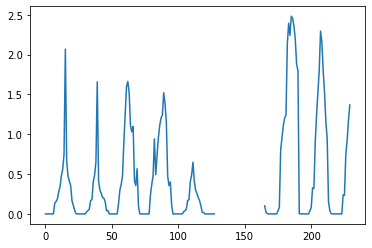

In [ ]:
plt.plot(mp1[:, 0])

In [ ]:
mark_ts(6, motifs=True, ts = ts2)

,Light,Index,Motif
date,,,
2015-02-11 17:00:00,419.000000,168,1
2015-02-12 17:00:00,423.500000,192,1
2015-02-06 18:00:00,0.000000,49,2
2015-02-11 18:00:00,0.000000,169,2
2015-02-12 18:00:00,0.000000,193,2
2015-02-07 16:00:00,14.000000,71,3
2015-02-13 19:00:00,0.000000,218,3
2015-02-04 18:00:00,0.000000,1,4
2015-02-06 17:00:00,433.000000,48,4


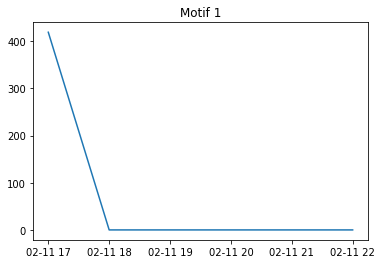

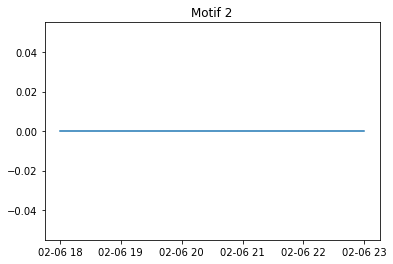

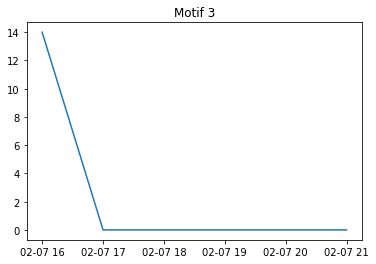

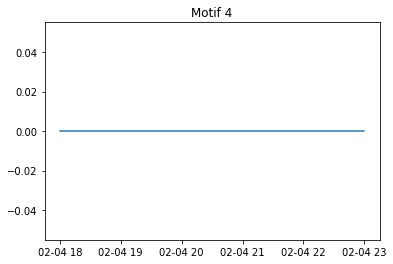

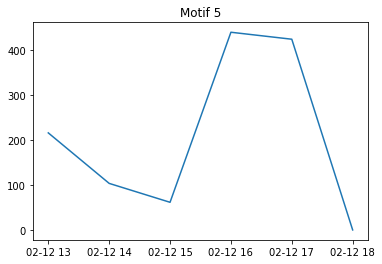

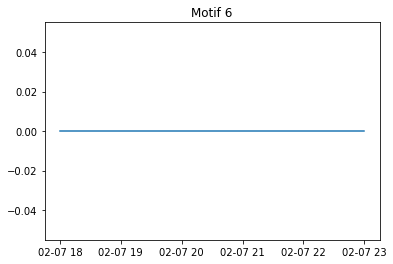

In [ ]:
motif_len = 6
motif_index = {}
for i in range(1, motif_len+1):
    idx = ts1.loc[ts2['Motif'] == str(i)].iloc[0].Index
    motif_index[i] = idx
motif_index

# per ogni motif possibile
for key, value in motif_index.items():
    # seleziona i 6 punti del motig
    ts_mot = ts2.iloc[value : value + motif_len]
    plt.plot(ts_mot['Light'])
    plt.title('Motif '+ str(key))
    plt.show()


In [ ]:
mark_ts(7, motifs=False, ts=ts2)

,Light,Index,Motif,Anomaly
date,,,,
2015-02-10 13:00:00,NaN,140,no,1
2015-02-10 10:00:00,NaN,137,no,1
2015-02-10 11:00:00,NaN,138,no,1
2015-02-10 12:00:00,NaN,139,no,1
2015-02-10 14:00:00,NaN,141,no,1
2015-02-10 15:00:00,NaN,142,no,1
2015-02-10 16:00:00,NaN,143,no,1
2015-02-10 17:00:00,NaN,144,no,1
2015-02-10 09:00:00,433.000000,136,no,1


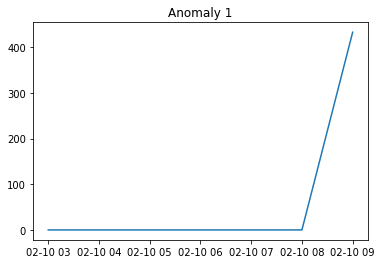

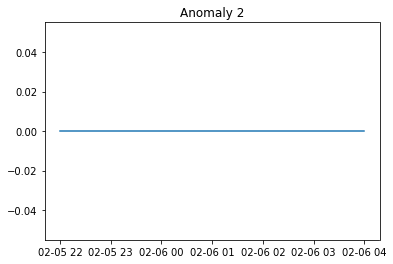

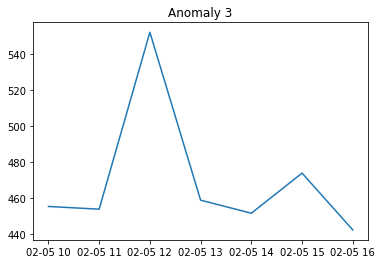

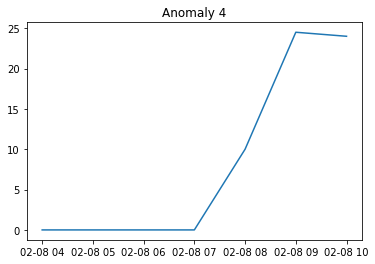

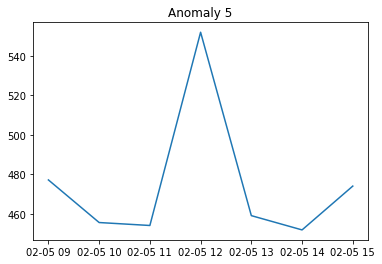

In [ ]:
anomalies_len = 7
anomalies_index = {}
for i in range(2, motif_len+1):
    idx = ts2.loc[ts2['Anomaly'] == str(i-1)].iloc[0].Index
    anomalies_index[i-1] = idx


# per ogni motif possibile
for key, value in anomalies_index.items():
    # seleziona i 6 punti del motig
    ts_mot = ts2.iloc[value : value + anomalies_len]
    plt.plot(ts_mot['Light'])
    plt.title('Anomaly '+ str(key))
    plt.show()


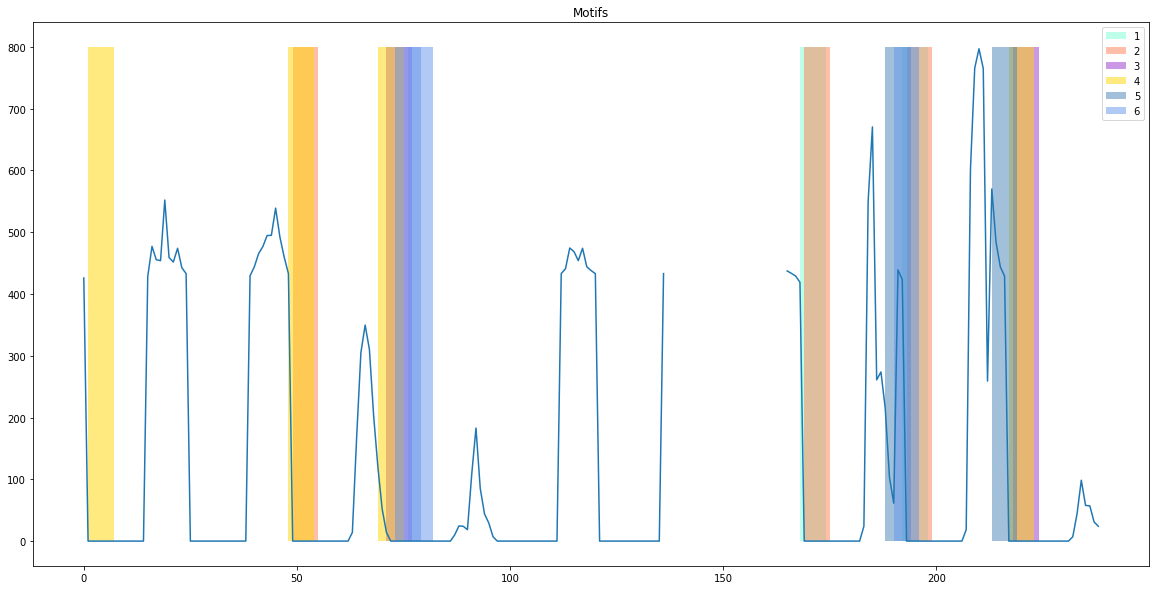

In [ ]:
from matplotlib.patches import Rectangle as Rect
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(20, 10))

n_rows = 239
min_height = 0
max_height = 800
# l'insieme dei motif da plottare
motif_list = ts2[ts2['Motif']!='no']
# questo serve perché erano stringhe
motif_list = motif_list.astype({'Motif': 'int32'})

#Plotta la ts
axs.plot(ts2['Light'].values)

# divido i motif per categoria
ids = list(motif_list['Motif'].unique())
# assegno a ogni motif un colore diverso
label_cols = {1 : '#7FFFD4', 2 : '#FF7F50', 3 : '#9932CC', 4 : '#FFD700', 5 : '#4682B4', 6: '#6495ED'}

# splitto il motif_list in df contenenti un unico tipo di motif
for motif_id in np.sort(ids):
    data = motif_list[motif_list['Motif'] == motif_id]
    # mi interessano solo le posizioni
    data = data['Index'].values
    for datum in data:
        # stampo i rect di quel motif dandogli il colore giusto rect((x, y), width, height)
        rect = Rect((datum, min_height), 6, max_height, facecolor=label_cols[motif_id], alpha=.5, label=motif_id)
        axs.add_patch(rect)

plt.title('Motifs')
# questa parte serve per plottare la legenda senza duplicare le label di ogni rettangolo
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

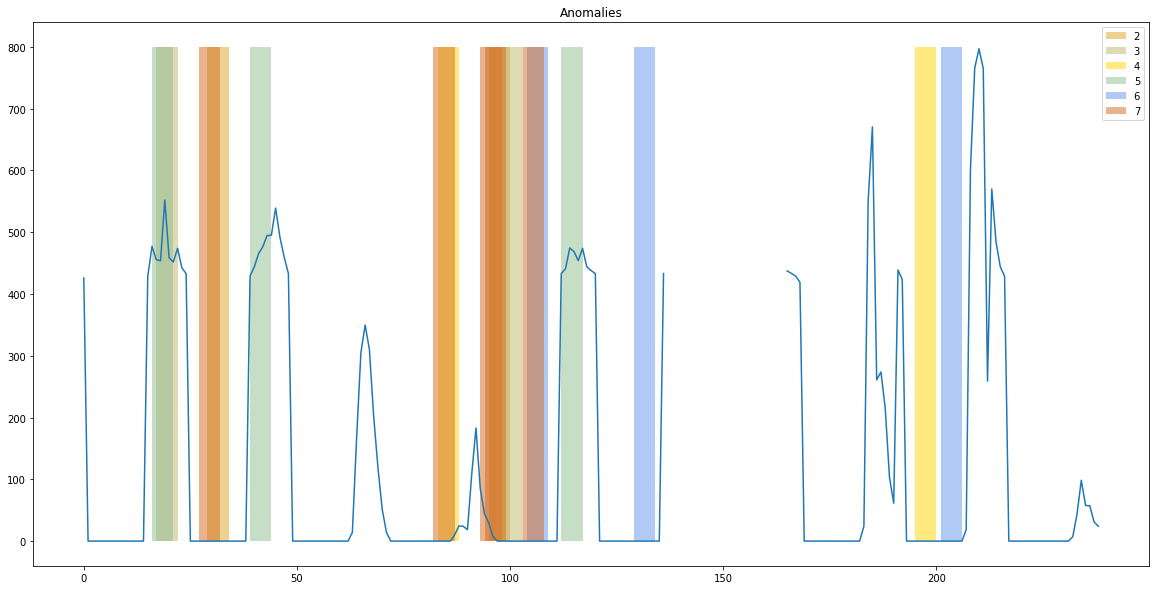

In [ ]:
from matplotlib.patches import Rectangle as Rect
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(20, 10))

n_rows = 239
min_height = 0
max_height = 800
# l'insieme dei motif da plottare
anomalies = ts2[ts2['Anomaly']!='no']
# questo serve perché erano stringhe
anomalies = anomalies.astype({'Anomaly': 'int32'})

#Plotta la ts
axs.plot(ts2['Light'].values)

# divido i motif per categoria
ids = list(anomalies['Anomaly'].unique())
ids = np.sort(ids)[1:]
# assegno a ogni motif un colore diverso
label_cols = {7 : '#D2691E', 2 : '#DAA520', 3 : '#BDB76B', 4 : '#FFD700', 5 : '#8FBC8F', 6: '#6495ED'}

# splitto il motif_list in df contenenti un unico tipo di motif
for anom_id in ids:
    data = anomalies[anomalies['Anomaly'] == anom_id]
    # mi interessano solo le posizioni
    data = data['Index'].values
    for datum in data:
        # stampo i rect di quel motif dandogli il colore giusto rect((x, y), width, height)
        rect = Rect((datum, min_height), 5, max_height, facecolor=label_cols[anom_id], alpha=.5, label=anom_id)
        axs.add_patch(rect)

plt.title('Anomalies')
# questa parte serve per plottare la legenda senza duplicare le label di ogni rettangolo
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

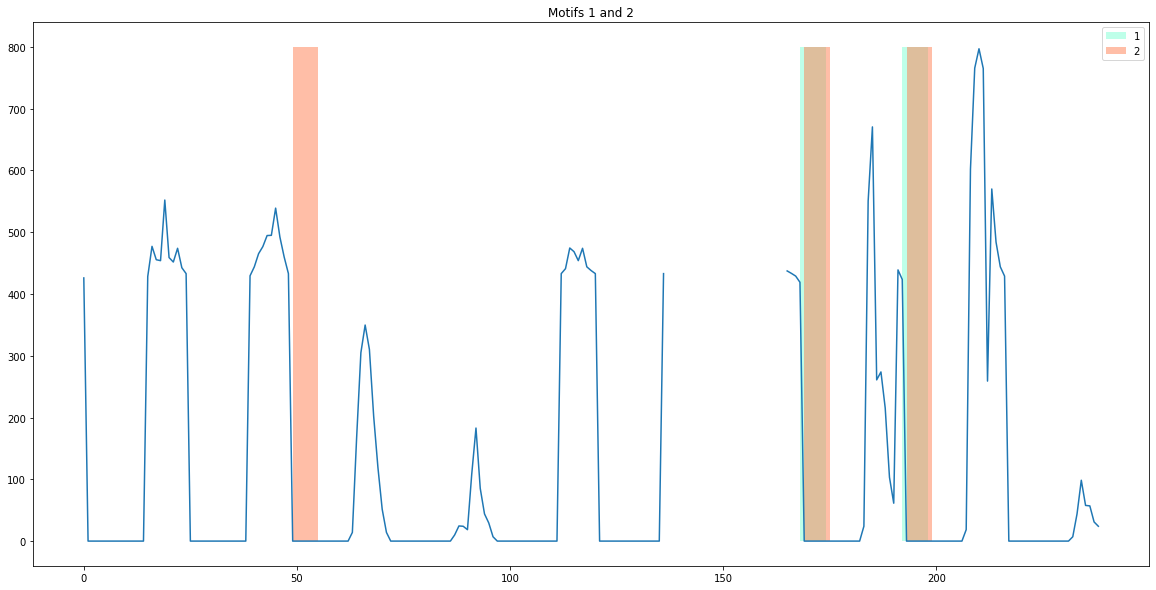

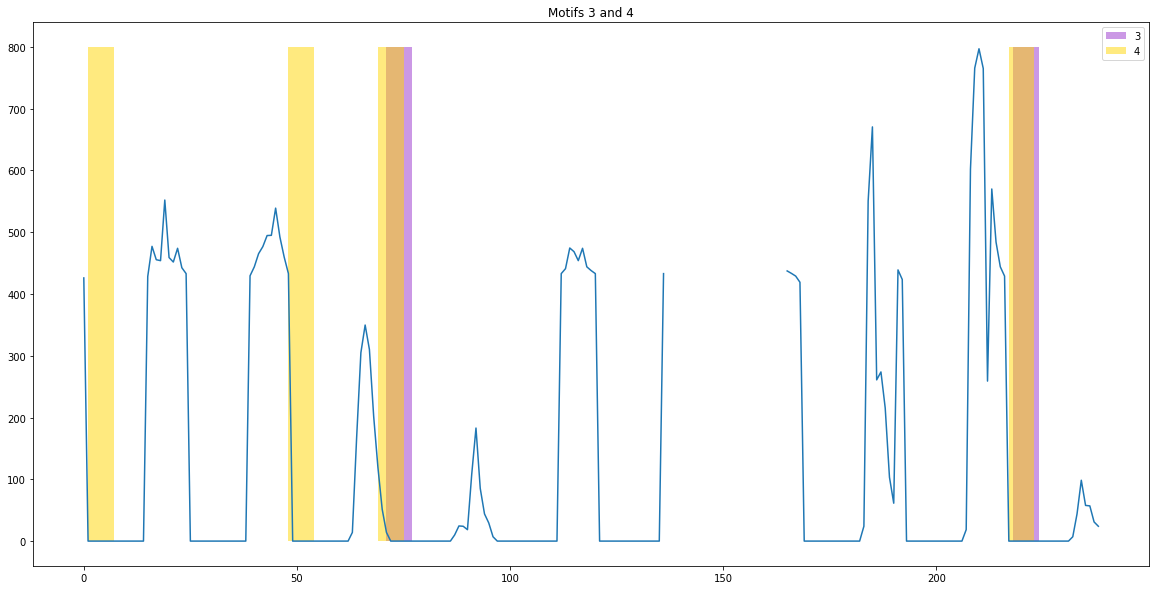

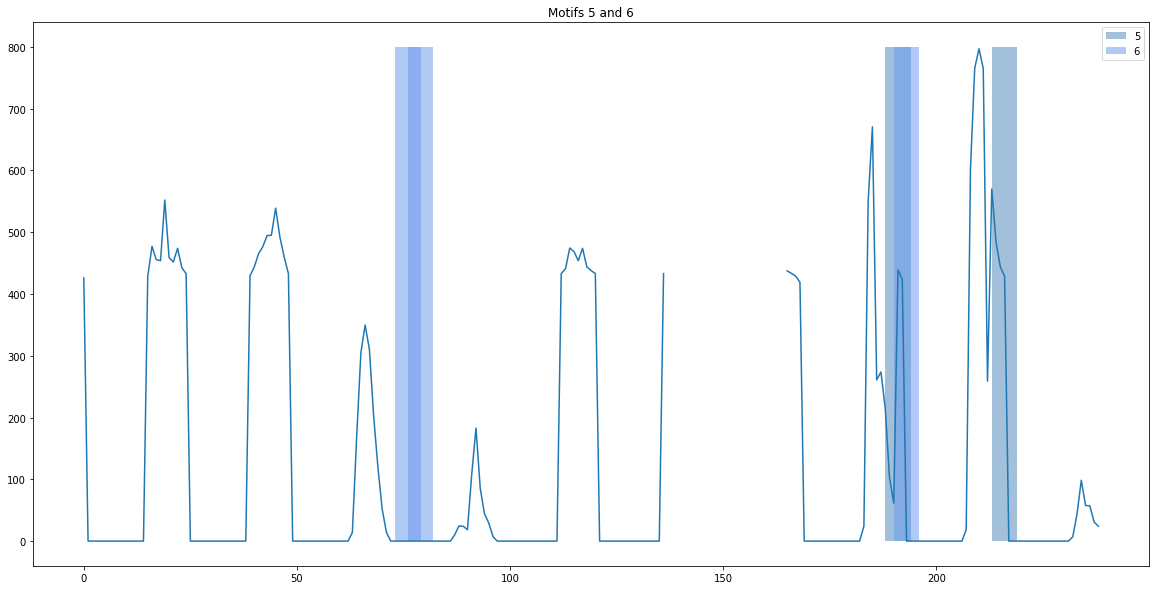

In [ ]:
from matplotlib.patches import Rectangle as Rect
n_rows = 239
min_height = 0
max_height = 800
# l'insieme dei motif da plottare
motif_list = ts2[ts2['Motif']!='no']
# questo serve perché erano stringhe
motif_list = motif_list.astype({'Motif': 'int32'})

# divido i motif per categoria
ids = list(motif_list['Motif'].unique())
ids = np.sort(ids)
# assegno a ogni motif un colore diverso
label_cols = {1 : '#7FFFD4', 2 : '#FF7F50', 3 : '#9932CC', 4 : '#FFD700', 5 : '#4682B4', 6: '#6495ED'}

i = 0
#for i in range(int(len(ids)/2)):
while i+1 < len(ids):
    fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(20, 10))
    #Plotta la ts
    axs.plot(ts2['Light'].values)

    id_1 = ids[i]
    id_2 = ids[i + 1]

    data = motif_list[motif_list['Motif'] == id_1]
    data = data['Index'].values
    for datum in data:
        rect = Rect((datum, min_height), 6, max_height, facecolor=label_cols[id_1], alpha=.5, label=id_1)
        axs.add_patch(rect)
    
    data = motif_list[motif_list['Motif'] == id_2]
    data = data['Index'].values
    for datum in data:
        rect = Rect((datum, min_height), 6, max_height, facecolor=label_cols[id_2], alpha=.5, label=id_2)
        axs.add_patch(rect)

    plt.title('Motifs '+ str(id_1)+ ' and ' +str(id_2))
    # questa parte serve per plottare la legenda senza duplicare le label di ogni rettangolo
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

    i += 2

[1 2 3 4 5 6 7]


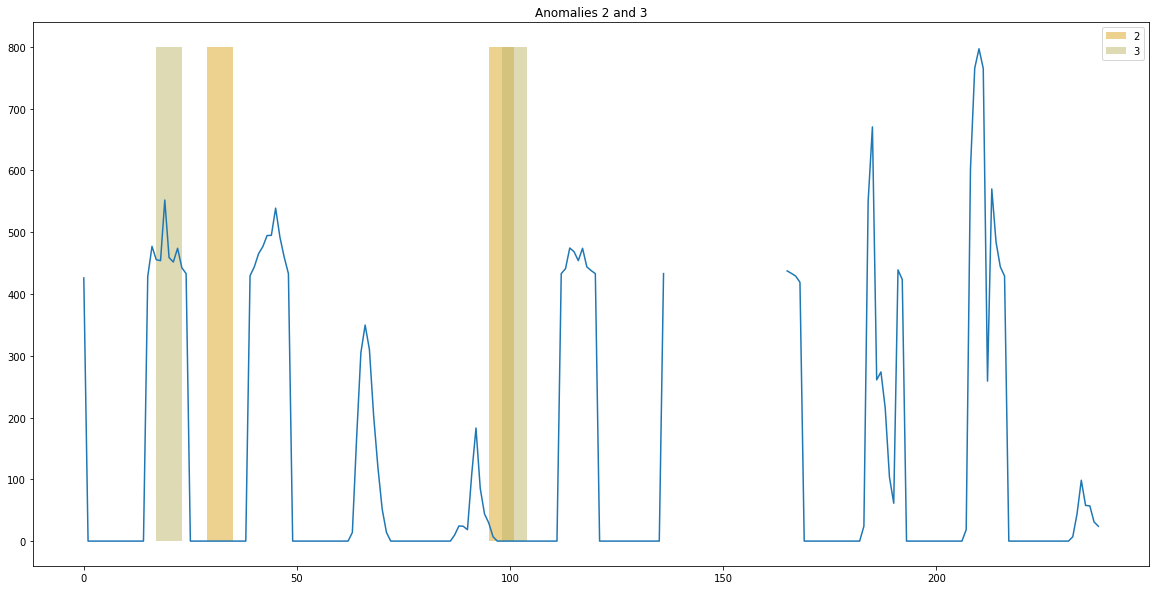

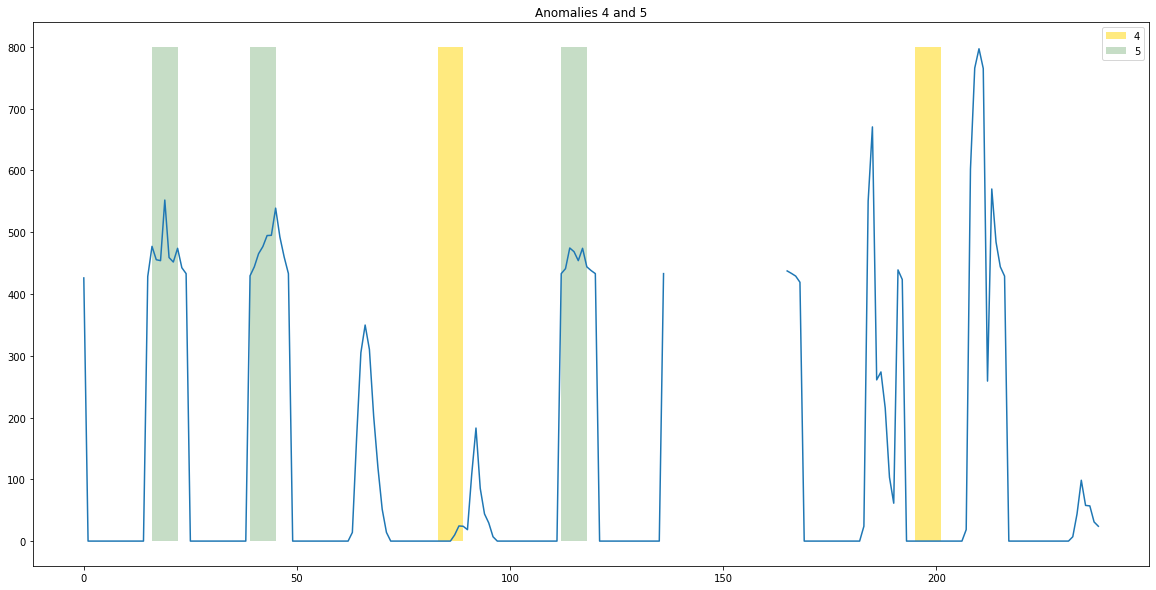

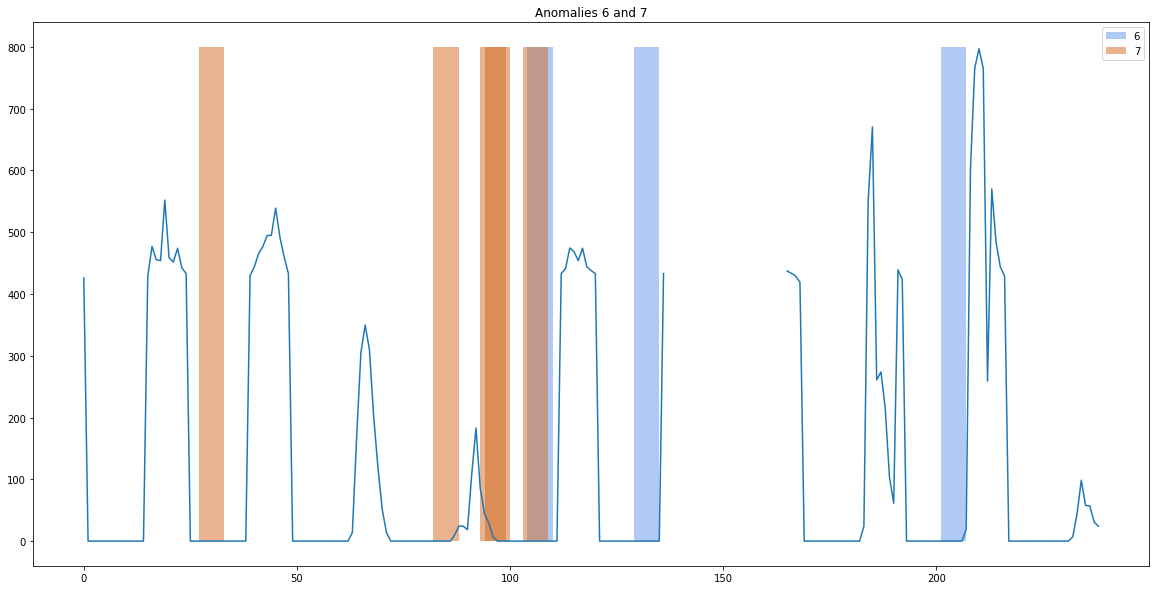

In [ ]:
from matplotlib.patches import Rectangle as Rect

n_rows = 239
min_height = 0
max_height = 800
# l'insieme dei motif da plottare
anomalies = ts2[ts2['Anomaly']!='no']
# questo serve perché erano stringhe
anomalies = anomalies.astype({'Anomaly': 'int32'})

#Plotta la ts
axs.plot(ts2['Light'].values)

# divido i motif per categoria
ids = list(anomalies['Anomaly'].unique())
ids = np.sort(ids)
print(ids)
# assegno a ogni motif un colore diverso
label_cols = {7 : '#D2691E', 2 : '#DAA520', 3 : '#BDB76B', 4 : '#FFD700', 5 : '#8FBC8F', 6: '#6495ED'}


i = 1
while i+1 < len(ids):
    fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(20, 10))
    #Plotta la ts
    axs.plot(ts2['Light'].values)

    id_1 = ids[i]
    id_2 = ids[i + 1]

    data = anomalies[anomalies['Anomaly'] == id_1]
    data = data['Index'].values
    for datum in data:
        rect = Rect((datum, min_height), 6, max_height, facecolor=label_cols[id_1], alpha=.5, label=id_1)
        axs.add_patch(rect)
    
    data = anomalies[anomalies['Anomaly'] == id_2]
    data = data['Index'].values
    for datum in data:
        rect = Rect((datum, min_height), 6, max_height, facecolor=label_cols[id_2], alpha=.5, label=id_2)
        axs.add_patch(rect)


    plt.title('Anomalies ' + str(id_1) + ' and ' + str(id_2))
    # questa parte serve per plottare la legenda senza duplicare le label di ogni rettangolo
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()
    i += 2